# Reducing Commercial Aviation Fatalities
##### by: Rehan Daya, Troy Walton, Yiwei Zhou, Emmanuella Eguche

In [1]:
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Assumption on Data Gathered

##### A= Train is collected in a non-flight environment.
##### B= Test is collected in a flight simulator

##### The goal is to predict the probability of each state for each time in the test set. We assume that the non-flight environment is equivalent to a flight simulator. Given the purpose of this experiement is likely to see the validity of the predictions in real life, and not only the flight simulator, we must also assume that A and B are equal to a real-flight environment (C).

##### As such A=B=C.

In [2]:
test = pd.read_csv('./test.csv') #This data is created from pilots in a flight simulator
train = pd.read_csv('./train.csv') #This data is created from pilots not in a flight simulator

In [3]:
train.head()

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,37.368999,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,31.170799,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,-12.012600,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,18.574100,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,6.555440,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A


In [4]:
test.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [5]:
# Create a new 'target' column with all 0
train['target'] = 0.0

# Mask the rows with non-base events and set them as different positive classes
mask = train['event'] == 'A'
train.loc[mask, 'target'] = 0.0
mask = train['event'] == 'B'
train.loc[mask, 'target'] = 1.0
mask = train['event'] == 'C'
train.loc[mask, 'target'] = 1.0
mask = train['event'] == 'D'
train.loc[mask, 'target'] = 1.0

train[:5]

,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,...,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event,target
0,1,CA,0.011719,1,-5.28545,26.775801,-9.527310,-12.793200,16.717800,33.737499,...,17.437599,19.201900,20.5968,-3.95115,14.507600,-4520.0,817.705994,388.829987,A,0.0
1,1,CA,0.015625,1,-2.42842,28.430901,-9.323510,-3.757230,15.969300,30.443600,...,19.399700,19.689501,21.3547,1.33212,17.750200,-4520.0,817.705994,388.829987,A,0.0
2,1,CA,0.019531,1,10.67150,30.420200,15.350700,24.724001,16.143101,32.142799,...,19.396299,23.171700,22.4076,1.53786,22.247000,-4520.0,817.705994,388.829987,A,0.0
3,1,CA,0.023438,1,11.45250,25.609800,2.433080,12.412500,20.533300,31.494101,...,23.156401,22.641199,19.3367,2.54492,18.998600,-4520.0,817.705994,388.829987,A,0.0
4,1,CA,0.027344,1,7.28321,25.942600,0.113564,5.748000,19.833599,28.753599,...,22.754700,22.670300,20.2932,1.69962,22.812799,-4520.0,817.705994,388.829987,A,0.0


In [6]:
"""# Create a new 'target' column with all 0
train['exp'] = 0.0

# Mask the rows with non-base events and set them as different positive classes
mask = train['experiment'] == 'SS'
train.loc[mask, 'exp'] = 1.0
mask = train['experiment'] == 'CA'
train.loc[mask, 'exp'] = 2.0
mask = train['experiment'] == 'DA'
train.loc[mask, 'exp'] = 3.0"""


"# Create a new 'target' column with all 0\ntrain['exp'] = 0.0\n\n# Mask the rows with non-base events and set them as different positive classes\nmask = train['experiment'] == 'SS'\ntrain.loc[mask, 'exp'] = 1.0\nmask = train['experiment'] == 'CA'\ntrain.loc[mask, 'exp'] = 2.0\nmask = train['experiment'] == 'DA'\ntrain.loc[mask, 'exp'] = 3.0"

In [7]:
Y, X = dmatrices('target ~ 0 + seat + time + r + gsr + eeg_fp1 +eeg_f7 + eeg_f8+eeg_t4+eeg_t6+\
                 eeg_t5 +eeg_t3+eeg_fp2+eeg_o1+eeg_p3+eeg_pz+eeg_f3+eeg_fz+eeg_f4+eeg_c4+eeg_p4+\
                 eeg_poz+eeg_c3+eeg_cz+eeg_o2+ecg',
                 train,return_type="dataframe")
print('Design matrix X')
print(X[:5])
print('Outcomes Y')
print(Y[:5])

Design matrix X
   seat      time           r         gsr   eeg_fp1     eeg_f7     eeg_f8  \
0   1.0  0.011719  817.705994  388.829987  -5.28545  26.775801  -9.527310   
1   1.0  0.015625  817.705994  388.829987  -2.42842  28.430901  -9.323510   
2   1.0  0.019531  817.705994  388.829987  10.67150  30.420200  15.350700   
3   1.0  0.023438  817.705994  388.829987  11.45250  25.609800   2.433080   
4   1.0  0.027344  817.705994  388.829987   7.28321  25.942600   0.113564   

      eeg_t4     eeg_t6     eeg_t5  ...     eeg_f3   eeg_fz    eeg_f4  \
0 -12.793200  16.717800  33.737499  ...  18.447001  1.07547   3.09029   
1  -3.757230  15.969300  30.443600  ...  20.510599  2.83354   7.10177   
2  24.724001  16.143101  32.142799  ...  23.162901  4.51993  12.70550   
3  12.412500  20.533300  31.494101  ...  19.961901  7.27575  11.45980   
4   5.748000  19.833599  28.753599  ...  18.746901  7.30976   8.00805   

      eeg_c4     eeg_p4    eeg_poz   eeg_c3   eeg_cz     eeg_o2     ecg  
0  37.36

In [8]:
model = sm.OLS(Y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.421
Model:                            OLS   Adj. R-squared (uncentered):              0.421
Method:                 Least Squares   F-statistic:                          1.414e+05
Date:                Sun, 09 Aug 2020   Prob (F-statistic):                        0.00
Time:                        19:11:59   Log-Likelihood:                     -3.4355e+06
No. Observations:             4867421   AIC:                                  6.871e+06
Df Residuals:                 4867396   BIC:                                  6.871e+06
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [9]:
result.pvalues

seat       0.000000e+00
time       0.000000e+00
r          0.000000e+00
gsr        0.000000e+00
eeg_fp1    2.438101e-69
eeg_f7     2.401436e-32
eeg_f8     6.184722e-19
eeg_t4     4.654031e-18
eeg_t6     3.271753e-03
eeg_t5     7.122670e-03
eeg_t3     1.234129e-05
eeg_fp2    3.615955e-48
eeg_o1     4.992639e-01
eeg_p3     5.974487e-10
eeg_pz     6.075269e-02
eeg_f3     3.712221e-26
eeg_fz     6.610666e-01
eeg_f4     3.365214e-02
eeg_c4     4.019989e-17
eeg_p4     1.460599e-05
eeg_poz    5.243119e-09
eeg_c3     1.106898e-03
eeg_cz     8.542574e-02
eeg_o2     2.184650e-05
ecg        0.000000e+00
dtype: float64

In [10]:
t = Y['target'].values
print(t[:5])

[0. 0. 0. 0. 0.]


Text(0, 0.5, 'gsr')

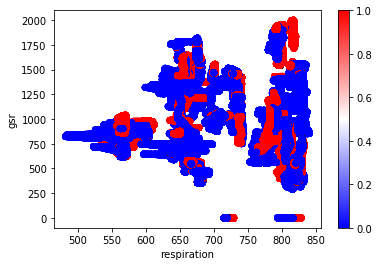

In [11]:
# scatter plot of distractedness related to respiration and gsr
sc = scatter(train['r'], train['gsr'], c = t, cmap = 'bwr')
colorbar(sc)
xlabel('respiration')
ylabel('gsr')

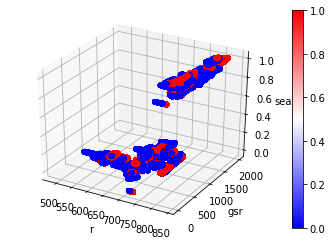

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =train['r']
y =train['gsr']
z =train['seat']

scatter_3d = ax.scatter(x, y, z, c=t, cmap = 'bwr', marker='o')
colorbar(scatter_3d)

ax.set_xlabel('r')
ax.set_ylabel('gsr')
ax.set_zlabel('seat')

plt.show()

y_test

## Logistic Regression

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, t, test_size=0.3, random_state=1)

In [15]:
# fit the classifier
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [16]:
# accuracy on test set
from sklearn import metrics

prediction_train = model.predict(X_train)
print("The accuracy of prediction without looking at the features is: ", metrics.accuracy_score(y_train, prediction_train))

The accuracy of prediction without looking at the features is:  0.5883821114970266


In [17]:
# y_train is 0 or 1.
print('Number of distracted events =', len(y_train[y_train==1]))
print('Number of baseline events =', len(y_train[y_train==0]))

Number of distracted events = 1413786
Number of baseline events = 1993408


In [18]:
baseline_events_in_test = len(y_test[y_test==0])
total_events_in_test = len(y_test)

print('Number of baseline events =', baseline_events_in_test)
print('Baseline event rate =', baseline_events_in_test * 1.0 / total_events_in_test)

Number of baseline events = 855401
Baseline event rate = 0.5858000160249057


In [19]:
# feature weights
model.coef_

array([[ 1.36973630e-04,  3.46923935e-04, -7.63103472e-04,
         2.72707403e-04, -8.66499184e-04,  5.77674552e-04,
         3.39387809e-04,  5.35762751e-04, -1.91682630e-05,
         1.43949788e-04,  3.66394240e-04, -5.91153980e-04,
        -1.29782440e-05,  2.47179990e-04,  6.26439935e-05,
        -3.12790302e-04, -2.23814264e-05,  1.08023965e-04,
        -2.90316077e-04,  9.71568408e-05,  2.85900455e-04,
         4.41937306e-07, -8.36104210e-05, -6.00972382e-05,
        -1.20128641e-05]])

In [20]:
model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# And the model intercept
model.intercept_

array([-3.63025965e-05])

In [22]:
model.classes_

array([0., 1.])

In [23]:
model.predict_proba(X_test)

array([[0.60741789, 0.39258211],
       [0.62712476, 0.37287524],
       [0.63673998, 0.36326002],
       ...,
       [0.52795654, 0.47204346],
       [0.63007397, 0.36992603],
       [0.53578948, 0.46421052]])

In [24]:
model.predict(X_test)

array([0., 0., 0., ..., 0., 0., 0.])

In [25]:
weights = Series(model.coef_[0],
                 index=X.columns.values)
w = weights.sort_values(ascending=False)

In [27]:
weights = pd.DataFrame(w, columns=['weight'])
#weights.set_index()
weights

,weight
eeg_f7,5.776746e-04
eeg_t4,5.357628e-04
eeg_t3,3.663942e-04
time,3.469239e-04
eeg_f8,3.393878e-04
eeg_poz,2.859005e-04
gsr,2.727074e-04
eeg_p3,2.471800e-04
eeg_t5,1.439498e-04
seat,1.369736e-04


In [29]:
pos = weights[weights['weight'] > 0]
neg = weights[weights['weight'] < 0]
neg

,weight
ecg,-0.000012
eeg_o1,-0.000013
eeg_t6,-0.000019
eeg_fz,-0.000022
eeg_o2,-0.000060
eeg_cz,-0.000084
eeg_c4,-0.000290
eeg_f3,-0.000313
eeg_fp2,-0.000591
r,-0.000763


In [30]:
value = weights[1:].sort_values(by = 'weight',ascending=False).values
weights[1:].sort_values(by = 'weight',ascending=False)

,weight
eeg_t4,5.357628e-04
eeg_t3,3.663942e-04
time,3.469239e-04
eeg_f8,3.393878e-04
eeg_poz,2.859005e-04
gsr,2.727074e-04
eeg_p3,2.471800e-04
eeg_t5,1.439498e-04
seat,1.369736e-04
eeg_f4,1.080240e-04


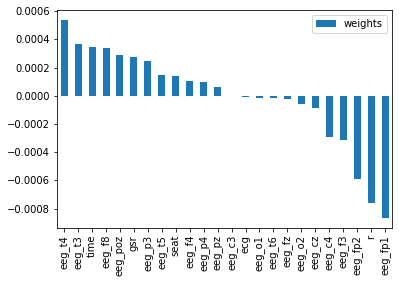

In [31]:
data = pd.DataFrame(value, index = weights[1:].index, columns = ['weights'])
data.plot(kind='bar')

**Observations**

* **eeg_fp2** and **respiration** has the most **negative** weights
    * a higher rating of **respiration** and **eeg_fp2** means the pilot is less likely to be distracted (higher $\Rightarrow$ less distracted)
* **seat = 0/1** has high positive weight $\Rightarrow$ more likely to be distracted when seat = 1 (right seat).
    * These corresponds to the pilot on the right seat.
    * This illustrates why captain is always seated on the left.
* **eeg_c4, eeg_p3, eeg_f8** have **positive** weights at around 0.002-0.0025. They are the most predictive factors of pilots' distractedness.
    * c4 is related to the inhibition of brain alpha waves (lack of concentration).
    * p3 node detects reactivity to external sensory stimulation.
    * f8 is correlated with frequent judgement control.
* On the other hand, **time** and **galvanic skin response** also have relatively high weights (the more time into experiment and the more skin response, the more distracted the pilots are.)

In [32]:
import statsmodels.api as sm

# identify the independent variables 
ind_cols=weights.index.values
logit = sm.Logit(y_test, X_test[ind_cols])
result=logit.fit()

Optimization terminated successfully.
         Current function value: 0.672661
         Iterations 4


In [33]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              1460227
Model:                          Logit   Df Residuals:                  1460202
Method:                           MLE   Df Model:                           24
Date:                Sun, 09 Aug 2020   Pseudo R-squ.:                0.008388
Time:                        19:20:54   Log-Likelihood:            -9.8224e+05
converged:                       True   LL-Null:                   -9.9055e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
eeg_f7         0.0005   7.75e-05      6.394      0.000       0.000       0.001
eeg_t4         0.0004      0.000      3.597      0.000       0.000       0.001
eeg_t3         0.0002   9.21e-05      2.479      0.0

In [34]:
dot = X_test.dot(model.coef_.T) + model.intercept_
dot

,0
349359,-0.436471
3489722,-0.519902
3553088,-0.561243
1855907,-0.414355
1025731,-0.567981
...,...
383982,-0.026360
3652787,-0.177565
2150220,-0.111943
1023991,-0.532534


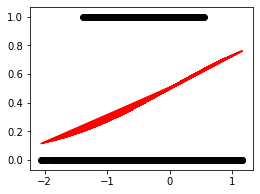

In [35]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
from sklearn import linear_model
from scipy.special import expit

# plot the result
clf = linear_model.LogisticRegression()
clf.fit(X_test, y_test)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(dot, y_test, color='black')

loss = expit(dot)
plt.plot(dot, loss, color='red')


Automatically created module for IPython interactive environment


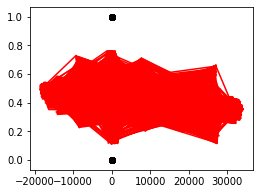

In [36]:
import matplotlib as mpl
from sklearn import linear_model
from scipy.special import expit

print(__doc__)

# Fit the classifier
model = LogisticRegression()
clf = model.fit(X_train, y_train)

# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(dot, y_test, color='black', zorder=2)

loss = expit(dot)
plt.plot(X_test, loss, color='red')
